# DataBass Project

Get the notes of the bass line from an audio file with multiple instruments

In [2]:
import sys
import os

path_DataBass = os.path.abspath('/Users/Ith/code/Lou-SdC/DataBass')
sys.path.append(path_DataBass)

import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from dotenv import load_dotenv

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from utils.get_note_baseline import get_pic_frequency, get_note, plot_fft
from preprocess.filter import frequencies_filter, plot_filtered_vs_original
from preprocess.spectrograms import generate_mel_spectrogram, plot_mel_spectrogram
from utils import bass_notes

from models.conv2D import create_model, preprocess_for_conv2D

from extract.bass_extract import extract_bass_list


In [3]:
%load_ext autoreload
%autoreload 2

We use the librosa library, which contains useful tools to load and process audio files.

First, lets extract the waveform and sample rate of one audio file :

In [4]:
filename = path_DataBass + '/raw_data/Bass monophon/Samples/Chorus/B11-28100-3311-00625.wav'
y, sr = librosa.load(filename)

The waveform (y) corresponds to the amplitude of the sound signal over time (well, over frames here). The sampling rate (sr) corresponds to how many times the signal was recorded per second (how many frames per second).

In [5]:
y

array([-5.6843419e-13, -8.2422957e-13, -9.0949470e-13, ...,
       -3.3662851e-05, -7.0256538e-06,  1.7327643e-06],
      shape=(44101,), dtype=float32)

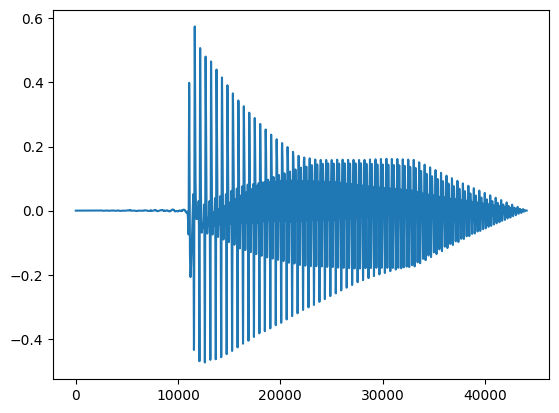

In [6]:
plt.plot(y)

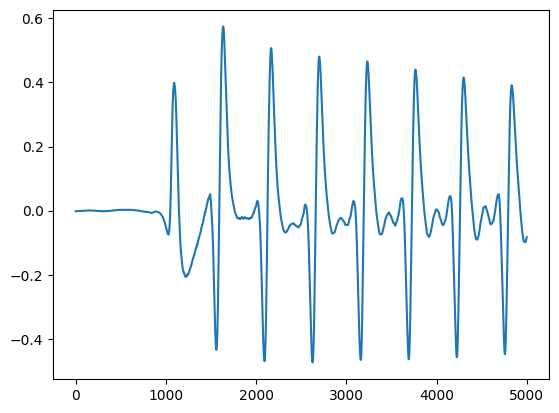

In [7]:
plt.plot(y[10000:15000])

In [8]:
test = librosa.pyin(y, fmin=20, fmax=400)
test

/var/folders/sq/pnm5zz592ds74m5gczbq870w0000gq/T/ipykernel_99561/2471812289.py:1: UserWarning: With fmin=20.000, sr=22050 and frame_length=2048, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=21.533 or frame_length=2207.
  test = librosa.pyin(y, fmin=20, fmax=400)


(array([        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan, 40.46477761, 40.93495568, 41.17208947, 41.41059695,
        41.41059695, 41.41059695, 41.41059695, 41.41059695, 41.41059695,
        41.41059695, 41.41059695, 41.41059695, 41.41059695, 41.41059695,
        41.41059695, 41.41059695, 41.41059695, 41.41059695, 41.41059695,
        41.41059695, 41.41059695, 41.41059695, 41.41059695, 41.41059695,
        41.41059695, 41.41059695, 41.41059695, 41.41059695, 41.41059695,
        41.41059695, 41.41059695, 41.41059695, 41.17208947, 41.41059695,
        41.41059695, 41.41059695, 41.41059695, 41.17208947, 41.41059695,
        41.41059695, 41.41059695, 41.41059695, 41.41059695, 41.41059695,
        41.41059695, 41.41059695, 41.41059695, 41.4

In [9]:
df_notes = pd.read_csv(path_DataBass + '/notebooks/lou/table_correspondance_notes_basse.csv')
print(df_notes)

   corde  case note  fréquence (Hz)
0      E     0   E1           41.20
1      E     1   F1           43.65
2      E     2  F♯1           46.25
3      E     3   G1           49.00
4      E     4  G♯1           51.91
..   ...   ...  ...             ...
95     G    20  D♯4          311.13
96     G    21   E4          329.63
97     G    22   F4          349.23
98     G    23  F♯4          370.00
99     G    24   G4          392.00

[100 rows x 4 columns]


In [10]:
pic_frequency, magnitude, frequencies = get_pic_frequency(y, sr)

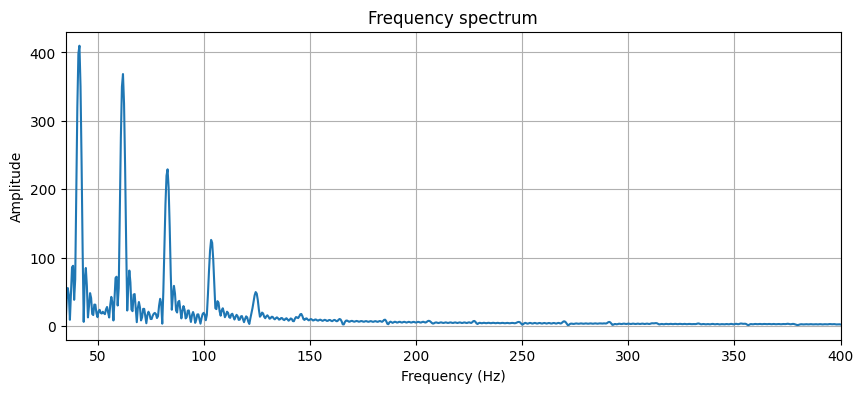

In [11]:
plot_fft(magnitude, frequencies)

In [12]:
get_note(pic_frequency, df_notes)

'E1'

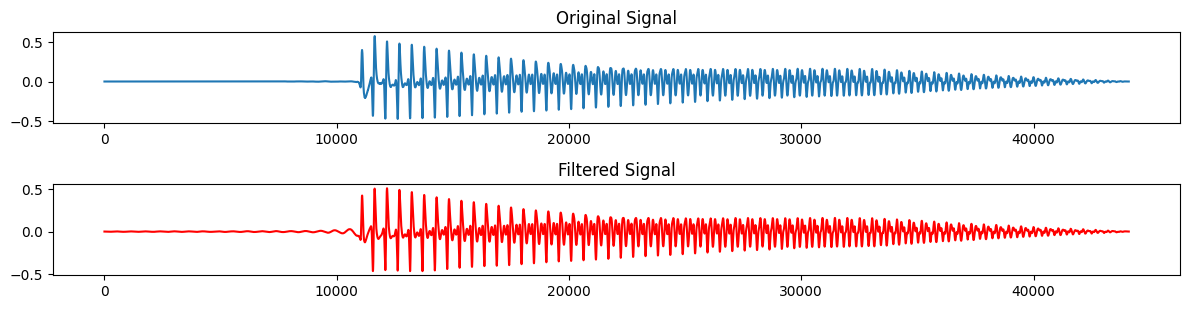

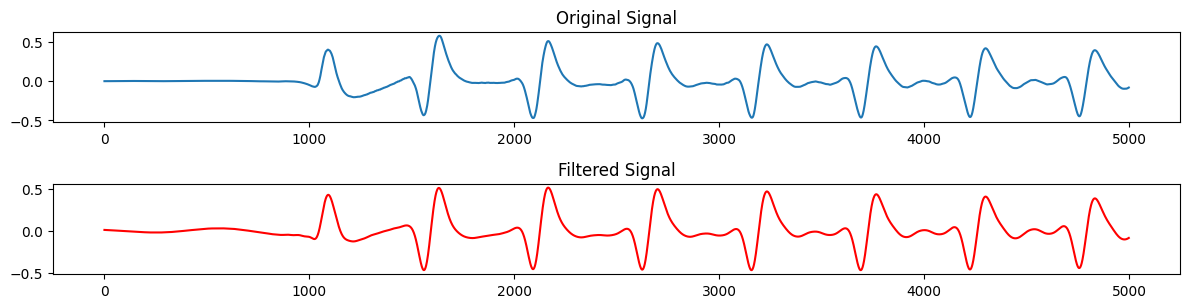

In [13]:
y_filtered = frequencies_filter(y, sr)

plot_filtered_vs_original(y, y_filtered)

In [14]:
print(sr)

22050


In [15]:

mel_spec = generate_mel_spectrogram(y, sr, normalize=False, target_shape=(128,128))
print("Shape du Mel-spectrogramme:", mel_spec.shape)  # (128, time_steps)


Shape du Mel-spectrogramme: (128, 128)


In [16]:
print(mel_spec)

[[-80.       -80.       -80.       ... -47.45098  -51.30227  -57.090538]
 [-80.       -80.       -80.       ... -42.103348 -45.86058  -50.48443 ]
 [-80.       -80.       -80.       ... -29.545357 -34.007202 -40.689857]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


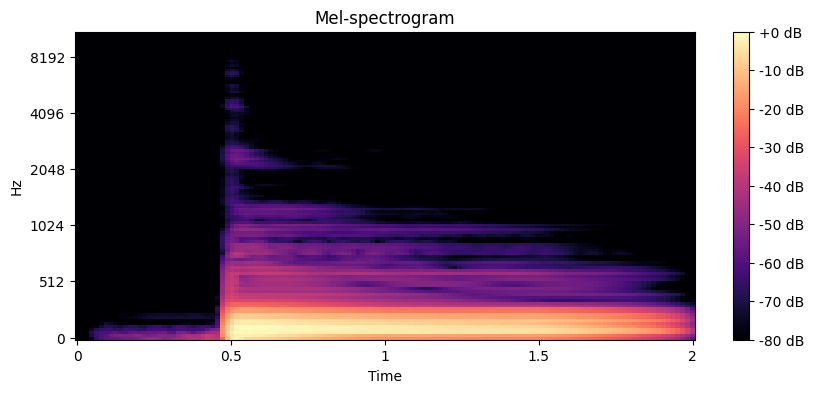

In [17]:
plot_mel_spectrogram(mel_spec, sr, y=y, target_shape=(128, 128))

In [18]:
df_targets = pd.read_csv(path_DataBass + '/data/preprocessed/chorus_bass_list.csv')
df_targets.head()

,fileID,instrument,instrumentsetting,playstyle,midinr,string,fret,fxgroup,fxtype,fxsetting,filenr,note_name,file_path
0,B31-28100-3312-01561,B,3,1,28,1,0,3,31,2,1561,E1,Bass monophon/Samples/Chorus/B31-28100-3312-01...
1,B31-29101-3312-01562,B,3,1,29,1,1,3,31,2,1562,F1,Bass monophon/Samples/Chorus/B31-29101-3312-01...
2,B31-30102-3312-01563,B,3,1,30,1,2,3,31,2,1563,F#1,Bass monophon/Samples/Chorus/B31-30102-3312-01...
3,B31-31103-3312-01564,B,3,1,31,1,3,3,31,2,1564,G1,Bass monophon/Samples/Chorus/B31-31103-3312-01...
4,B31-32104-3312-01565,B,3,1,32,1,4,3,31,2,1565,G#1,Bass monophon/Samples/Chorus/B31-32104-3312-01...


In [19]:
label1 = 'B31-28100-3312-01561.wav'
label1_name = label1.replace('.wav', '')
print(label1_name)
df_targets[df_targets['fileID'] == label1_name]['note_name'].values[0]

B31-28100-3312-01561


'E1'

In [20]:
audio_dir = path_DataBass + '/raw_data/Bass monophon/Samples/Chorus'

X = []
y = []
labels = []

for label in os.listdir(audio_dir):

    # get the audio file
    y_audio, sr = librosa.load(audio_dir + '/' + label, sr=None)

    # create mel_spectrogram
    mel_spec = generate_mel_spectrogram(y_audio, sr, target_shape=(128,128),
                                        duration=2.0, normalize='minmax')

    # get the target
    label_name = label.replace('.wav', '')
    target = df_targets[df_targets['fileID'] == label_name]['note_name'].values[0]

    # add to lists
    X.append(mel_spec)
    y.append(target)
    labels.append(label)

X = np.array(X)


In [ ]:
# Optionnel : voir la correspondance classe -> entier
#print("Classes (note -> id):")
#for note, idx in zip(le.classes_, range(len(le.classes_))):
#    print(f"{note} -> {idx}")

In [22]:
X_train, X_test, X_val, y_train, y_test, y_val, le = preprocess_for_conv2D(X, y)

In [23]:
print(len(labels))
print(X.shape)
print(len(y))
print(y)
print(len(np.unique(y)))

1872
(1872, 128, 128)
1872
['G#2', 'F#2', 'E3', 'G#1', 'B1', 'F#3', 'A#1', 'C2', 'D2', 'A#1', 'C#2', 'C#2', 'A1', 'A1', 'A2', 'D#2', 'G#2', 'D3', 'F#3', 'D3', 'F3', 'C3', 'C2', 'E2', 'D3', 'C#3', 'G2', 'E1', 'F2', 'F#2', 'F3', 'E2', 'C#2', 'B2', 'B2', 'F#2', 'D#2', 'E2', 'E2', 'F2', 'G3', 'B1', 'B2', 'C3', 'G2', 'B2', 'G2', 'A#1', 'A2', 'A#1', 'A2', 'D2', 'A#2', 'D3', 'F#1', 'F#3', 'D#2', 'C#2', 'C3', 'F#1', 'D#3', 'A2', 'D#3', 'F3', 'F#3', 'A2', 'F#2', 'D#2', 'F#3', 'E1', 'G1', 'G#2', 'E2', 'G#1', 'C2', 'A1', 'C3', 'G#1', 'A1', 'G#2', 'B1', 'F#2', 'C#3', 'C#3', 'F3', 'B2', 'G2', 'B1', 'C#3', 'G#1', 'D#3', 'G#2', 'D2', 'A#1', 'C#2', 'A#2', 'C3', 'G2', 'G2', 'G2', 'F#2', 'G2', 'D2', 'C#3', 'G#2', 'F#2', 'C3', 'C#2', 'A2', 'A1', 'F#3', 'G2', 'G#2', 'C#2', 'F1', 'B1', 'G1', 'F1', 'A#1', 'D2', 'F#1', 'A2', 'G#2', 'C#2', 'D2', 'C#3', 'D3', 'G1', 'F#3', 'E1', 'G2', 'A#2', 'C2', 'C3', 'A#2', 'F2', 'A#2', 'A2', 'G#2', 'D#2', 'G#1', 'F#2', 'G#1', 'A#2', 'B1', 'G#2', 'F#2', 'B2', 'E1', 'A#2', 'F

In [26]:
# Créer le modèle
input_shape = X_train.shape[1:]  # (128, 128, 1)
num_classes = len(np.unique(y))
model = create_model(input_shape, num_classes)

# Afficher le modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,307,676 (12.62 MB)

 Trainable params: 3,307,676 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
es = EarlyStopping(
    monitor='val_loss',       # Metrique à surveiller (perte sur le jeu de validation)
    patience=5,               # Nombre d'époques sans amélioration avant l'arrêt
    restore_best_weights=True, # Restaure les poids du modèle à l'époque avec la meilleure performance
    verbose=1                 # Affiche un message quand l'arrêt précoce est déclenché
)

# Entraînement
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    callbacks=[es],
    validation_data=(X_val
                     , y_val),
    verbose=1
)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.0660 - loss: 3.2808 - val_accuracy: 0.1253 - val_loss: 3.1417
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.1649 - loss: 2.8435 - val_accuracy: 0.3493 - val_loss: 2.2766
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.4804 - loss: 1.8021 - val_accuracy: 0.6907 - val_loss: 1.1307
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.6676 - loss: 1.0954 - val_accuracy: 0.8560 - val_loss: 0.5996
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.7674 - loss: 0.7250 - val_accuracy: 0.8987 - val_loss: 0.4272
Restoring model weights from the end of the best epoch: 5.


In [35]:
model.save('modele_lou_10-12-25_11h.keras')

In [23]:
new_file = 'raw_data/Bass monophon/Samples/Distortion/B11-28100-4411-06241.wav'

In [33]:
X_train.shape

(1122, 128, 128, 1)

In [28]:
from tensorflow.keras.models import load_model

# Charger le modèle
model = load_model(path_DataBass + '/notebooks/lou/modele_lou_10-12-25_11h.keras')

print("Conv2D model loaded successfully.")

# load exemple .wav
exemple_wav = os.path.join(
    path_DataBass,
    'raw_data',
    'Bass monophon',
    'Samples',
    'Chorus',
    'B11-28100-3311-00625.wav')

y, sr = librosa.load(exemple_wav)

s = generate_mel_spectrogram(y, sr, normalize='minmax')

print(s.shape)

s = np.expand_dims(s, axis=-1)
s = np.expand_dims(s, axis=0)

print(f'Preprocessed shape: {s.shape}')

result = model.predict(
    s
)
predicted_classes = np.argmax(result, axis=1)

print("Indices des classes prédites :", predicted_classes)

# Récupérer les notes originales
predicted_notes = le.inverse_transform(predicted_classes)
print("Notes prédites :", predicted_notes)

Conv2D model loaded successfully.
(128, 128)
Preprocessed shape: (1, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Indices des classes prédites : [14]
Notes prédites : ['E1']


In [30]:
from models.conv2D import conv2D_predict_note

note = conv2D_predict_note(s, model, le)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted note : ['E1']
